# CMSC 33750
## HW 2
## Lynn Zheng

---

# Writeup

## 1. How you prepared the data for clustering. 
I cleaned the data, removing non-gene features and genes with zero counts. I stored the data into a $N \times P$ matrix, where $N$ is the number of patients/samples and $P$ is the number of genes/features. There are 500 PT and 44 TN samples and 14k+ genes.

Interestingly, from the results of the analysis, normalizing the data doesn't seem to have a significant impact on the error rate. For appropriate methods, we get similar results for raw and normalized data.

## 2.What algorithms that you used for clustering.
I used K-Means with $k=2$ as well as hierarchical clustering. For K-Means, I also tried first reducing the data dimensionality with PCA before running K-Means.

## 3.How you visualized the clustering.
I reduced the data dimensionality to 2 using PCA and t-SNE, and then plot it on a 2D figure.

## 4.How you convinced yourself that the clustering was valid.
The clusters identified by K-Means aren't very good, probably because K-Means doesn't work well with high-dimensional data, where the number of features far exceeds the number of samples. The best error rate resulting from K-Means is about 37%. It's obtained from either directly using the raw data or using normalized data reduced to the first three principle components. The reduced-dimension results are better as in the plots that follow.

The clusters identified by hierarchical clustering aren't satisfactory either. The best error rate from hierachical clustering is about 8%. It is obtained from using single linkage with either raw or normalized data. However, when visualizing the clusters, it appears that the tree places all but one points into one cluster and another into a singleton cluster when we specifies the number of cluster to be 2.

The clustering plot makes the most sense visually (and with a low error rate of 13%) resulted from using complete linkage on normalized data reduced to 3D (preprocessed by PCA). Please see the last plot in this notebook.

High-dimensional data that are complicated in nature (like RNA-Seq) weakens the performace of K-Means and hierarchical clustering algorithms.

## 5.Any biological interpretations that you can associate with the clusters (extra credit).
Some interesting observations:
1. A few principle components explain the majority of the variability in the data (the first PC explains almost 25% of the variance)
> This might be pointing to the fact that a few genes are significant for clustering cancer vs. non-cancer cases.

2. Single linkage works "best" in terms of error rate but results in a singleton cluster and an all-but-one-point cluster when we perform hierarchical clustering
> This implies that the clustering algorithm might be confused when the distance between two clusters (that are about to be merged) is determined solely by the pair of samples that are closest to each other. The variations in gene expressions might have been very small between every pair of data points. The algorithm might have thought that two samples may still belong to the same class despite small variations in their gene expressions and hence repeated merge any two nearby clusters/data points.

3. Complete linkage seems to have produced visually sound clustering and has a low error rate.
> It makes more sense that the distance between two clusters is determined by all pairwise distances between samples belonging to the two clusters. Otherwise, a small outlier in gene expression could have completely disrupted the results, producing invalid clusters like single linkage did.

4. Reducing data dimension with PCA first achieves better performance for both K-Means and hierarchical clustering.
> This is not surprising as a lot of the gene variations/features might just be confounding factors and some might even have colinearity. PCA reduces such noise.

In conclusion, RNA-seq data is very high-dimensional and noisy. Some preprocessing like normalization, experimenting with different scalers, eliminating outliers, and first reducing dimensions with PCA, might help to reduce the noise.

Our unbalanced sample set (a lot more PT than TN) might also have posed a challenge to both K-Means and bottom-up hierarchical clustering. This might indicate that there is too much variability in the population with tumor to the extent that there doesn't exist an "average" cancer patient. Two randomly drawn samples from that population might be more similar to each other than how much they are similar to the "population average."

# RNA-Seq Clustering

## Getting Data from GDC

I used two different queries to look up files for TP and NT on GDC (advanced search), added the files to cart, and downloaded separate manifest files for TP and NT. There are 500 files in the TP manifest and 44 files in the NT manifest.

The two queries differ in that the first specified `cases.samples.sample_type in ["primary tumor"]` and the second `cases.samples.sample_type in ["solid tissue normal"]`.

The main body of the query is the same as what I used in HW1:
```
cases.project.project_id in ["TCGA-HNSC"] and files.analysis.workflow_type in ["HTSeq - Counts"] and files.data_category in ["transcriptome profiling"] and files.experimental_strategy in ["RNA-Seq"]
```

I then extracted the UUIDs from the manifest file, constructed a JSON request body, and made a POST request to GDC using curl to download the files. The API endpoint for downloading files is `https://api.gdc.cancer.gov/data`. The download took about 5 minutes and has about 160 MB.

I put PT `htseq.counts` data into `data/primary_tumor/` and NT data into `data/solid_tissue_normal/`.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# normalize data
from sklearn.preprocessing import Normalizer
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from IPython.display import display

In [21]:
def write_json_file(manifest):
    with open(manifest, 'rt') as f:
        lines = f.readlines()[1:] # skip header
    uuids = [line.split('\t')[0] for line in lines]
    jso = {'ids': uuids}
    jso_fname = manifest.split('.manifest.txt')[0] + '.json'
    with open(jso_fname, 'wt') as f:
        json.dump(jso, f)

In [22]:
write_json_file('data/primary_tumor.manifest.txt')
write_json_file('data/solid_tissue_normal.manifest.txt')

In [24]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/primary_tumor.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  119M    0  119M  100 20009   312k     51  0:06:32  0:06:29  0:00:03  303k:37  0:00:37 --:--:--  254k00 20009   188k    308  0:01:04  0:01:04 --:--:--  251k5M  100 20009   304k     59  0:05:39  0:05:35  0:00:04  137k
curl: Saved to filename 'gdc_download_20201014_205700.202302.tar.gz'


In [25]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/solid_tissue_normal.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M    0 10.4M  100  1769   234k     38  0:00:46  0:00:45  0:00:01  240k0  1769  99892    442  0:00:04  0:00:04 --:--:-- 99920
curl: Saved to filename 'gdc_download_20201014_210309.859494.tar.gz'


# Reading and Cleaning Data

We remove non-gene columns: `__no_feature, __ambiguous, __too_low_aQual, __not_aligned, __alignment_not_unique`

Read data from the two directors as a $N \times P$ matrix

$N$: num rows/samples/observations/patients  
$P$: num columns/features/genes

In [64]:
def read_data_matrix(directories):
    """
    returns P * N dataframe
    """
    dataframes = []
    sample_idx = 0
    for idx, directory in enumerate(directories):
        files = os.listdir(directory)
        for f in files:
            sample_idx += 1
            # drop non-gene columns and 0
            df = pd.read_csv(os.path.join(directory, f), 
                             sep='\t', header=None, 
                             index_col=0, # use gene name as index
                             names=['gene', 
                                    'sample{}'.format(sample_idx)])
            df.drop(['__no_feature', '__ambiguous', 
                     '__too_low_aQual', '__not_aligned', 
                     '__alignment_not_unique'], inplace=True)
            df.replace(0, np.nan, inplace=True)
            df.dropna(inplace=True)
            
            dataframes.append(df)
    ret_df = pd.concat(dataframes, axis=1, join='inner')
    return ret_df

In [68]:
raw_data = read_data_matrix(['data/primary_tumor', 
                             'data/solid_tissue_normal'])

In [116]:
# data cleaning
data = raw_data.T # N samples * P genes
data.columns.name = 'sample'
data.reset_index(inplace=True)
data.drop(columns=['index'], inplace=True)
# add disease status label column, PT vs. TN
data['disease'] = \
['PT' for _ in range(len(os.listdir('data/primary_tumor')))] + \
['TN' for _ in range(len(os.listdir('data/solid_tissue_normal')))]

In [ ]:
data.to_csv('data/clean/data.csv')

## Load Clean Data

In [2]:
data = pd.read_csv('data/clean/data.csv', index_col=0)

In [214]:
data.head()

,ENSG00000000003.13,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,ENSG00000001460.16,...,ENSG00000281207.1,ENSG00000281332.1,ENSG00000281344.1,ENSG00000281357.1,ENSG00000281404.1,ENSG00000281406.1,ENSG00000281490.1,ENSG00000281501.1,ENSG00000281649.1,disease
0,2254.0,1268.0,689.0,979.0,108.0,1035.0,2006.0,21315.0,1591.0,1181.0,...,15.0,88.0,76.0,20.0,60.0,256.0,196.0,24.0,2765.0,PT
1,3113.0,2076.0,944.0,1223.0,159.0,6516.0,6214.0,3425.0,1628.0,859.0,...,35.0,111.0,105.0,14.0,42.0,160.0,113.0,63.0,3472.0,PT
2,6344.0,2938.0,494.0,631.0,144.0,569.0,4196.0,9345.0,2316.0,2505.0,...,26.0,115.0,106.0,22.0,161.0,118.0,59.0,74.0,2484.0,PT
3,1416.0,2329.0,801.0,777.0,199.0,1481.0,3352.0,37391.0,2832.0,744.0,...,7.0,307.0,11.0,33.0,28.0,307.0,142.0,54.0,3813.0,PT
4,2287.0,2782.0,629.0,464.0,341.0,7388.0,2413.0,7231.0,2224.0,1019.0,...,41.0,156.0,62.0,35.0,125.0,523.0,165.0,85.0,2676.0,PT


In [149]:
data.shape

(544, 14349)

We have 500 PT + 44 TN = 544 samples and 14349 - 1 = 14348 genes as features (the last column is the patient's disease status).

# Before Normalizing, Show PCA for Raw Data

In [16]:
# produce X and y
matrix = data.loc[:, data.columns != 'disease'].to_numpy()
# 0 for PT and 1 for TN
int_labels = data['disease'].astype('category').cat.codes

In [17]:
def visualize_2d(X_2d, y, labels, title):
    target_ids = range(len(labels))
    fig = plt.figure(figsize=(14, 6))
    for i, c, label in zip(target_ids, 'rgbcmykw', labels):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],
                   c=c, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

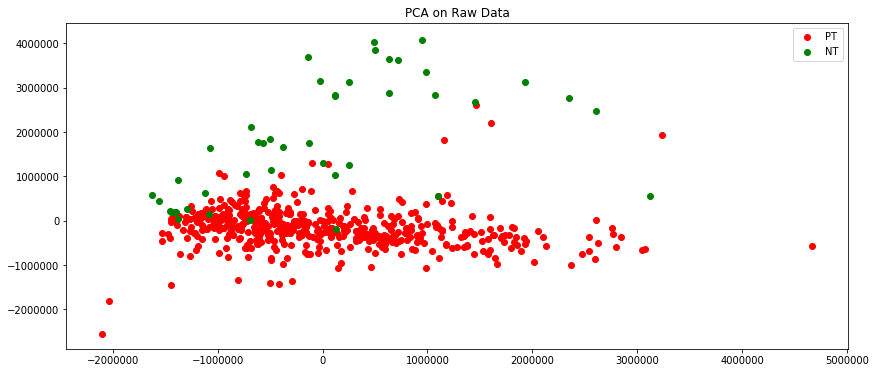

In [18]:
matrix_pca = PCA(n_components=2).fit_transform(matrix)
visualize_2d(matrix_pca, int_labels, ['PT', 'NT'], 'PCA on Raw Data')

## Let's see how K-Means perform on non-normalized data

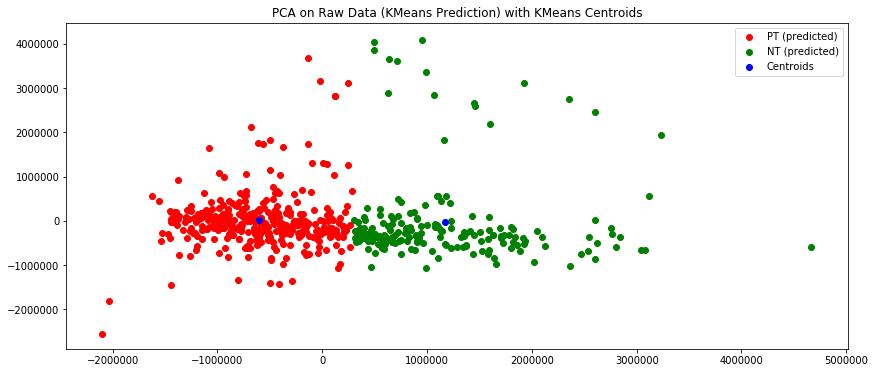

In [21]:
matrix_kmeans = KMeans(n_clusters=2, random_state=0).fit(matrix)
matrix_kmeans_pca = PCA(n_components=2).fit_transform(
    np.concatenate([matrix, matrix_kmeans.cluster_centers_]))

visualize_2d(matrix_kmeans_pca, 
             np.concatenate([matrix_kmeans.labels_, [2, 2]]), 
             ['PT (predicted)', 'NT (predicted)', 'Centroids'], 
             'PCA on Raw Data (KMeans Prediction) with KMeans Centroids')

In [22]:
# the number of mistakes K-Means made
np.sum(int_labels != matrix_kmeans.labels_)

201

We observe that the clusters K-Means produced aren't very good. It made 201 mistakes. Let's see if we get better performance with normalization.

# Normalizing Counts

In [23]:
normalized = Normalizer().fit_transform(matrix)

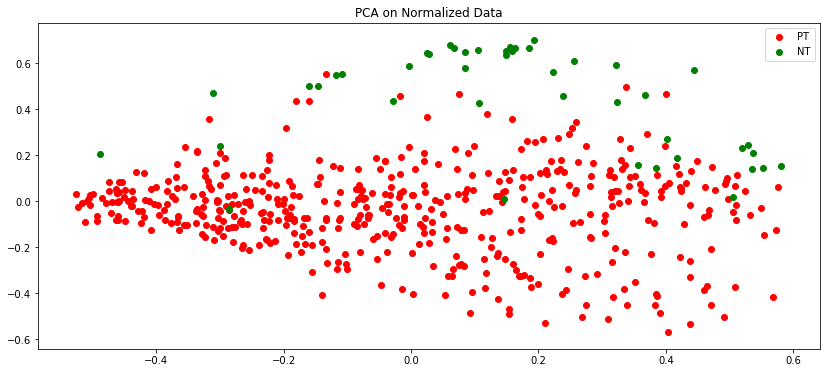

In [24]:
normalized_pca = PCA(n_components=2).fit_transform(normalized)
visualize_2d(normalized_pca, int_labels, ['PT', 'NT'], 'PCA on Normalized Data')

We observe that the normalized data seems more separable than the raw data on the 2D PCA plot.

In [273]:
# first apply PCA to reduce dim and speed up t-SNE
temp = PCA(n_components=50).fit_transform(normalized)
normalized_tsne = TSNE(n_components=2, verbose=1).fit_transform(temp)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 544 samples in 0.007s...
[t-SNE] Computed neighbors for 544 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 544 / 544
[t-SNE] Mean sigma: 0.186253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.056709
[t-SNE] KL divergence after 1000 iterations: 0.877019


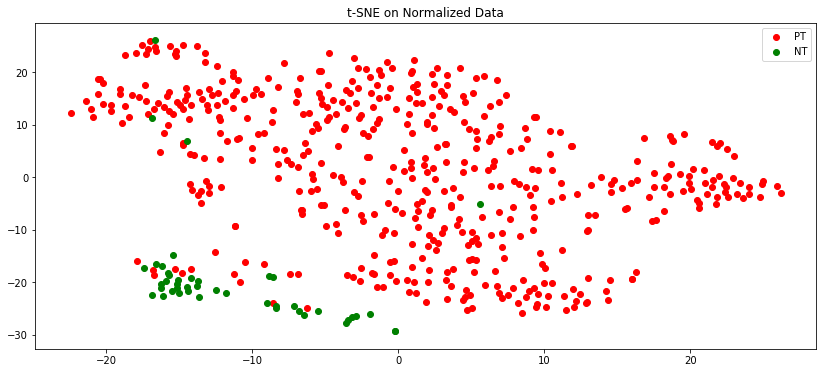

In [274]:
visualize_2d(normalized_tsne, int_labels, ['PT', 'NT'], 't-SNE on Normalized Data')

The t-SNE plot shows that the two clusters should be separable by a good enough clustering algorithm.

# K-Means Clustering on Normalized Data

In [25]:
normalized_kmeans = KMeans(n_clusters=2, random_state=0).fit(normalized)

In [26]:
# the number of mistakes K-Means made
np.sum(int_labels != normalized_kmeans.labels_)

310

In [27]:
with_centroids = PCA(n_components=2).fit_transform(
    np.concatenate([normalized, normalized_kmeans.cluster_centers_]))

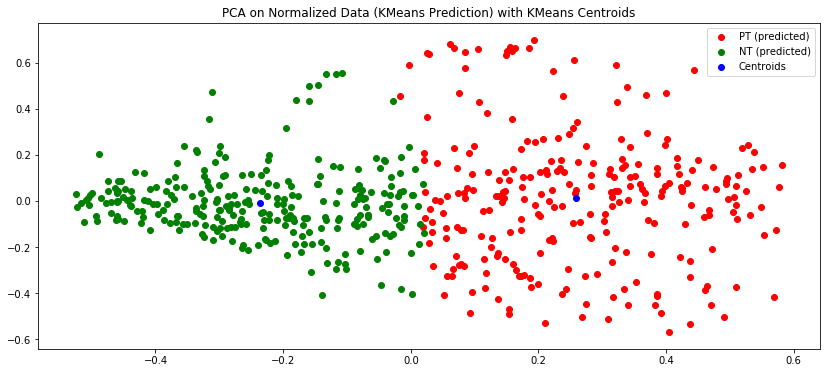

In [28]:
visualize_2d(with_centroids, 
             np.concatenate([normalized_kmeans.labels_, [2, 2]]), 
             ['PT (predicted)', 'NT (predicted)', 'Centroids'], 
             'PCA on Normalized Data (KMeans Prediction) with KMeans Centroids')

As we can observe from the difference between the true labels and K-Means prediction (301 wrong labels), performing K-Means clustering on normalized data still doesn't give us sufficiently good results. If we are using the number of wrong labels as a criterion, K-Means on normalized data actually performs worse than K-Means on raw, non-normalized data.

# Try First Reducing Dimensionality with PCA
One possible cause for the failure of K-Means might be that Euclidean distance tend to work poorly in high-dimensional space. We only have 544 samples but 14k+ features. Let's try reducing the number of features by looking at PCA's variance cutoff.

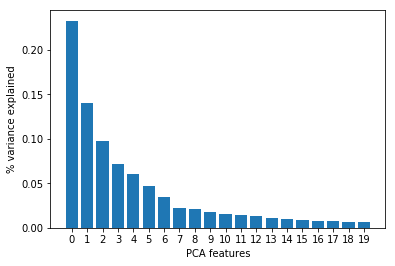

In [10]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(normalized)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('% variance explained')
plt.xticks(features)
plt.show()

The above plot shows that a few (1, 2, or 3) principle components already captures the variance well. Let's try clustering only on the first three principle components.

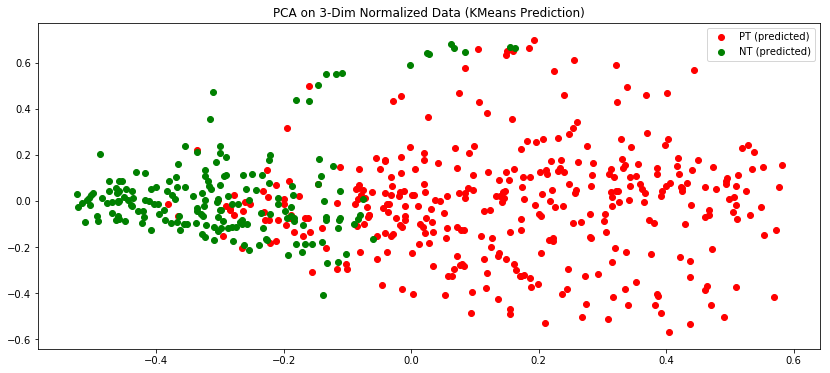

In [39]:
normalized_3 = PCA(n_components=3).fit_transform(normalized)
normalized_3_kmeans = KMeans(n_clusters=2, random_state=0).fit(matrix)
visualize_2d(normalized_pca, normalized_3_kmeans.labels_, ['PT (predicted)', 'NT (predicted)'], 
             'PCA on 3-Dim Normalized Data (KMeans Prediction)')

In [30]:
# the number of mistakes K-Means made
np.sum(int_labels != normalized_3_kmeans.labels_)

201

Unfortunately, K-Means still perform poorly. There is at least some improvement in that it recognizes some points toward the top of the figure as NT, which agrees with their true labels. Moreover, the number of wrong labels have decreased from 310 to 201, but it's still a 37% error rate.

# We next explore hierarchical clustering algorithms
Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [16]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

We first look at the full tree by not specifying the number of clusters

In [35]:
normalized_dendro = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None).fit(normalized)

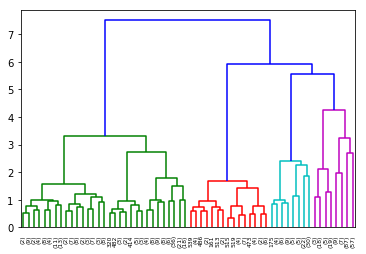

In [36]:
plot_dendrogram(normalized_dendro, truncate_mode='level', p=5)

Specify two clusters. Try linkage methods like `ward (min variance)`, `complete`, `average`, `single`. For normalized data, our distance metric (`euclidean`) is equivalent to `cosine`.

In [34]:
def num_wrong_labels(X, y, **kwargs):
    dendro = AgglomerativeClustering(n_clusters=2, **kwargs).fit(X)
    num_wrong = np.sum(y != dendro.labels_)
    return num_wrong

In [41]:
# raw data, ward linkage
num_wrong_labels(matrix, int_labels)

320

In [54]:
# raw data, single linkage
num_wrong_labels(matrix, int_labels, linkage='single')

45

An interesting observation is that there isn't much difference between using raw and normalized data.

In [42]:
# normalized data, ward linkage
num_wrong_labels(normalized, int_labels)

257

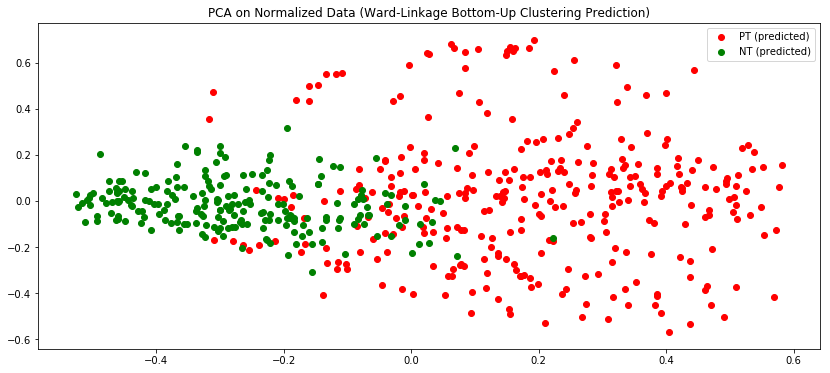

In [32]:
normalized_ward = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(normalized)
visualize_2d(normalized_pca, normalized_ward.labels_, ['PT (predicted)', 'NT (predicted)'], 
             'PCA on Normalized Data (Ward-Linkage Bottom-Up Clustering Prediction)')

In [43]:
# normalized data reduced to first three principle components
num_wrong_labels(normalized_3, int_labels)

366

In [45]:
# normalized data, complete linkage
num_wrong_labels(normalized, int_labels, linkage='complete')

270

In [46]:
# normalized data, average linkage
num_wrong_labels(normalized, int_labels, linkage='average')

506

In [47]:
# normalized data, single linkage
num_wrong_labels(normalized, int_labels, linkage='single')

45

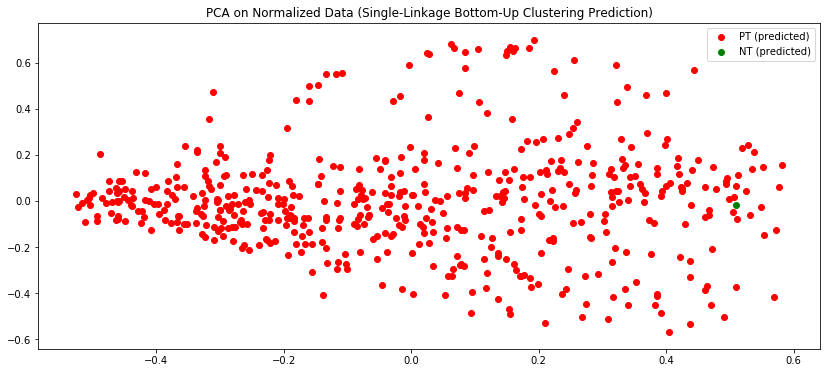

In [14]:
normalized_single = AgglomerativeClustering(n_clusters=2, linkage='single').fit(normalized)
visualize_2d(normalized_pca, normalized_single.labels_, ['PT (predicted)', 'NT (predicted)'], 
             'PCA on Normalized Data (Single-Linkage Bottom-Up Clustering Prediction)')

We seem to get the best clustering results (in the sense of the fewest wrong labels) using either raw or normalized data, single-linkage hierarchical clustering. The error rate is about 8%.

Now try using normalized data reduced to 3D by PCA.

In [35]:
# normalized 3D data, ward linkage
num_wrong_labels(normalized_3, int_labels)

366

In [38]:
# normalized 3D data, ward linkage
num_wrong_labels(normalized_3, int_labels, linkage='complete')

69

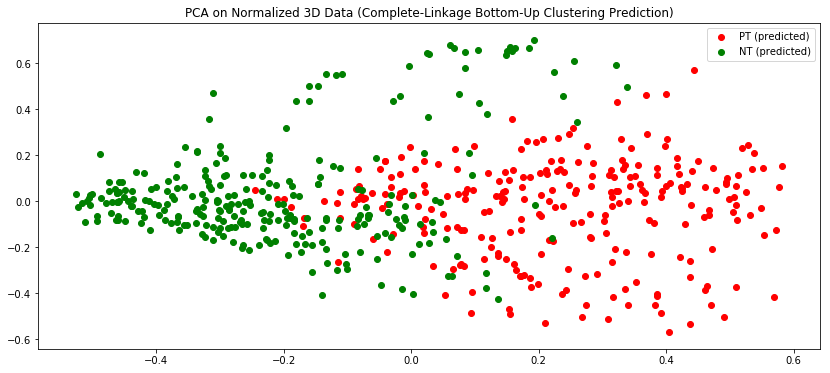

In [40]:
normalized_3_complete = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(normalized)
visualize_2d(normalized_pca, normalized_3_complete.labels_, ['PT (predicted)', 'NT (predicted)'], 
             'PCA on Normalized 3D Data (Complete-Linkage Bottom-Up Clustering Prediction)')